Plot confidence-temperature graphs for labelled transition videos

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
from keras import Model

In [8]:
#file_title = "Video_phase_recognition2"
file_title = "Kaggle4"
directory = "C:/Users/Jason/Documents/University/Year_4/MPhys_project/Project_work/Data/I-N-Chol-Sm_dataset-balanced/Results/Old_smaller_dataset_model/"

In [9]:
model_load_dir = directory + file_title + "_saved_model" 
trained_model = tf.keras.models.load_model(model_load_dir)

for layer in trained_model.layers:
  layer.trainable = False

trained_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 256, 256, 1)       0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 256, 256, 1)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 256, 256, 1)       0         
_________________________________________________________________
random_zoom (RandomZoom)     (None, 256, 256, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 252, 252, 16)      416       
_________________________________________________________________
batch_normalization (BatchNo (None, 252, 252, 16)      64        
_________________________________________________________________
activation (Activation)      (None, 252, 252, 16)      0

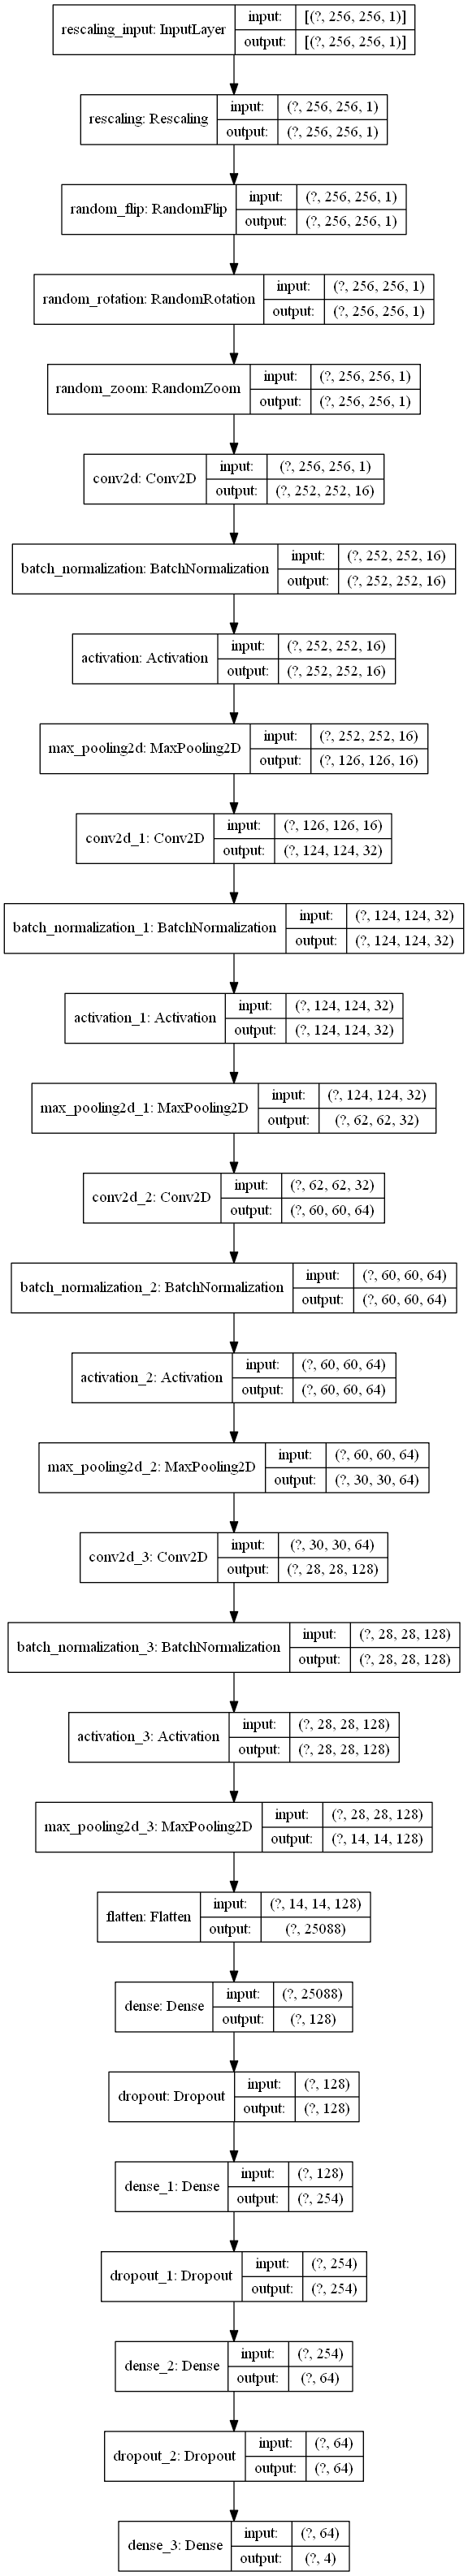

In [10]:
model_save_path = directory + "model.png"
plot_model(trained_model, to_file=model_save_path, show_shapes=True, show_layer_names=True)

In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [12]:
target_names = ["Isotropic", "Nematic", "Cholesteric", "Smectic"]

In [13]:
test_dir = directory + "val"

In [14]:
fixed_test_datagen = ImageDataGenerator()
fixed_test_generator = fixed_test_datagen.flow_from_directory(test_dir,
                                                batch_size = 32,
                                                class_mode = "categorical",
                                                color_mode = "grayscale",
                                                target_size = (256,256),
                                                shuffle = False
                                               )

Found 736 images belonging to 4 classes.


In [15]:
predictions = trained_model.predict(fixed_test_generator, verbose=1)
y_pred = np.argmax(predictions, axis=1)

y_true = fixed_test_generator.classes

23/23 [==============================] - 22s 975ms/step


In [16]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       186
           1       0.50      1.00      0.67       166
           2       0.86      0.72      0.78       191
           3       0.43      0.13      0.21       193

    accuracy                           0.70       736
   macro avg       0.70      0.71      0.66       736
weighted avg       0.70      0.70      0.66       736



In [18]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True, save=True):
    """
    from: https://www.kaggle.com/grfiv4/plot-a-confusion-matrix
    """
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    
    if save:
        plt.savefig(directory + (file_title) + "-test_confusion_matrix")
    
    plt.show()

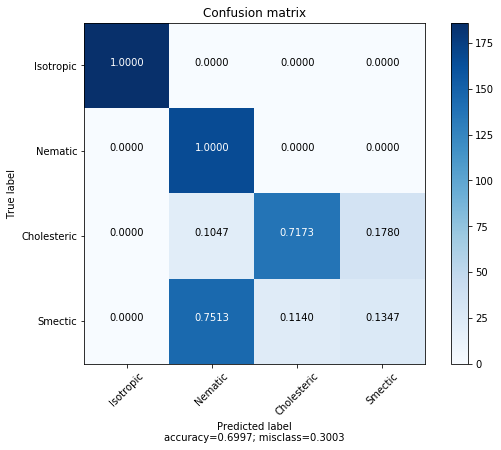

In [19]:
cm = confusion_matrix(y_true, y_pred)

plot_confusion_matrix(cm,
                      target_names,
                      title="Confusion matrix",
                      normalize=True,
                      save=True
                     )

In [5]:
import cv2
import collections
import pandas as pd

In [98]:
video_file_name = "M6/M6-Green_heating_124_150C_10Cmin"
vid_path = "C:/Users/Jason/Documents/University/Year_4/MPhys_Project(s)/Liquid_crystals-machine_learning/(I,N,Chol,Sm)Test_videos-balanced/" + video_file_name + ".avi"
vid_name = "M6_124-150"

start_temp = 124
end_temp = 150
temp_rate_per_sec = 10/60

#vid_save_path = file_title + "_" + video_file_name + "_temperature_labelled.avi"
vid_save_path = vid_name + ".avi"
vid_stream = cv2.VideoCapture(vid_path)

writer = None
width = int(vid_stream.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(vid_stream.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = int(vid_stream.get(cv2.CAP_PROP_FOURCC))

fps = vid_stream.get(cv2.CAP_PROP_FPS)
frame_count = int(vid_stream.get(cv2.CAP_PROP_FRAME_COUNT))
vid_duration = frame_count/fps

temp_step_per_frame = temp_rate_per_sec/fps

temp_list = []
phase_list = []
I_con = []
N_con = []
Chol_con = []
Sm_con = []

In [99]:
i = 0
while True:
    (grabbed, frame) = vid_stream.read()
    if not grabbed:
        break
        
    output_vid = frame.copy()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    #frame = cv2.resize(frame, (256, 256)).astype("float32") / 255
    frame = cv2.resize(frame, (256, 256)).astype("float32")
    
    # get phase prediction for frame
    pred = trained_model.predict(np.expand_dims(frame, axis=(0,3)))
    y_predict = np.argmax(pred, axis=1)
    confidence = pred[0][y_predict]
    I_confidence = pred[0][0]
    N_confidence = pred[0][1]
    Chol_confidence = pred[0][2]
    Sm_confidence = pred[0][3]
    label = target_names[int(y_predict)]
    
    # get temperature of frame
    temp = start_temp + i*temp_step_per_frame
    i += 1
    # store data for plotting
    temp_list.append(temp)
    phase_list.append(label)
    I_con.append(I_confidence)
    N_con.append(N_confidence)
    Chol_con.append(Chol_confidence)
    Sm_con.append(Sm_confidence)
    
    phase_text = "Phase: {}".format(label)
    phase_confidence_text = "Confidence: {}".format(confidence)
    temp_text = "Temperature: %.1f C"%(temp)
    cv2.putText(output_vid, phase_text, (35,50), cv2.FONT_HERSHEY_SIMPLEX,
               1.25, (255, 255, 255), 5)
    cv2.putText(output_vid, phase_confidence_text, (35,100), cv2.FONT_HERSHEY_SIMPLEX,
               1.25, (255, 255, 255), 5)
    cv2.putText(output_vid, temp_text, (35,150), cv2.FONT_HERSHEY_SIMPLEX,
               1.25, (255, 255, 255), 5)
    
    if writer is None:
        writer = cv2.VideoWriter(vid_save_path, fourcc, fps, (width, height), True)
        
    writer.write(output_vid)
    
    cv2.imshow("Output_vid", output_vid)
    key = cv2.waitKey(1) & 0xFF
    
    if key == ord("q"):
        break
        

writer.release()
vid_stream.release()
cv2.destroyAllWindows()

In [100]:
temp_list = np.array(temp_list).reshape(len(temp_list), 1)
phase_list = np.array(phase_list).reshape(len(phase_list), 1)
I_con = np.array(I_con).reshape(len(I_con), 1)
N_con = np.array(N_con).reshape(len(N_con), 1)
Chol_con = np.array(Chol_con).reshape(len(Chol_con), 1)
Sm_con = np.array(Sm_con).reshape(len(Sm_con), 1)

data = np.hstack((temp_list, phase_list, I_con, N_con, Chol_con, Sm_con))

column_headers = ["Temperature", "Phase", "I_confidence", "N_confidence", "Chol_confidence", "Sm_confidence"]

temp_confidence_data = pd.DataFrame(data = data, columns = column_headers)

temp_confidence_data.head()

,Temperature,Phase,I_confidence,N_confidence,Chol_confidence,Sm_confidence
0,124.0,Cholesteric,0.000641534,0.0008308427,0.7602703,0.23825733
1,124.01156363468165,Cholesteric,0.0007042715,0.0009278448,0.7652742,0.23309362
2,124.0231272693633,Cholesteric,0.0006326502,0.00083273277,0.76786894,0.23066564
3,124.03469090404496,Cholesteric,0.0006399654,0.0008382572,0.77157515,0.22694671
4,124.04625453872661,Cholesteric,0.00061319995,0.0008107079,0.7751778,0.22339836


In [101]:
train_data_file_path = "C:/Users/Jason/Documents/University/Year_4/MPhys_Project(s)/Liquid_crystals-machine_learning/LiquidCrystalMachineLearning/Video_classification/Confidence-temperature_data/" + vid_name + ".csv"

In [102]:
temp_confidence_data.to_csv(train_data_file_path)

In [103]:
iso = np.array(temp_confidence_data["I_confidence"][:].astype(float))
nematic = np.array(temp_confidence_data["N_confidence"][:].astype(float))
chol = np.array(temp_confidence_data["Chol_confidence"][:].astype(float))
smectic = np.array(temp_confidence_data["Sm_confidence"][:].astype(float))
temp = np.array(temp_confidence_data["Temperature"][:].astype(float))

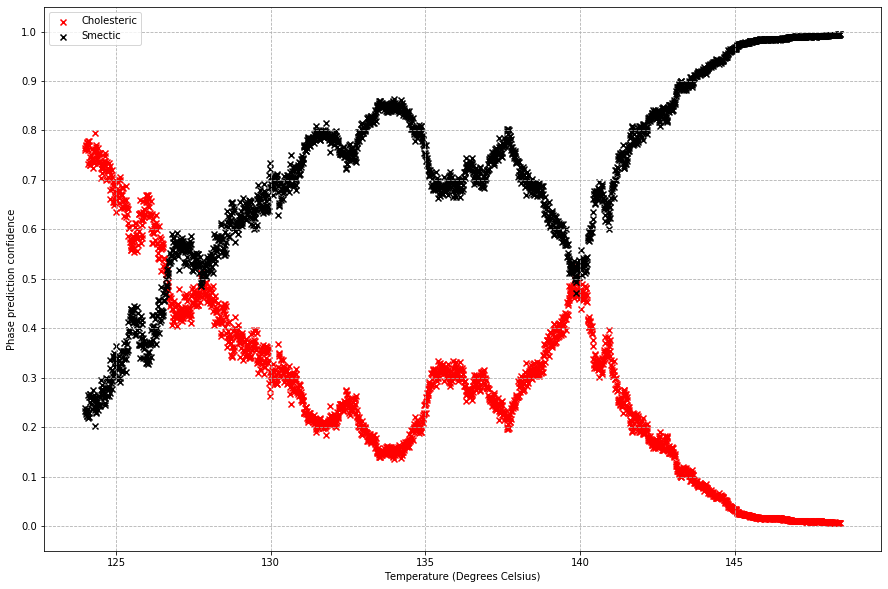

In [105]:
plt.figure(figsize=(15,10))
#plt.scatter(temp, iso, c="g", marker="x", label="Isotropic")
#plt.scatter(temp, nematic, c="b", marker="x", label="Nematic")
plt.scatter(temp, chol, c="r", marker="x", label="Cholesteric")
plt.scatter(temp, smectic, c="black", marker="x", label="Smectic")

plt.xlabel("Temperature (Degrees Celsius)")
#plt.xticks(np.arange(78, 101, 2))
#plt.xlim(start_temp - 0.1, end_temp - 0.7)
plt.ylabel("Phase prediction confidence")
plt.yticks(np.arange(0, 1.1, 0.1))

plt.legend(loc="best")
plt.grid(linestyle="--")

plt.savefig(vid_name + "_full_confidence-temp_graph")

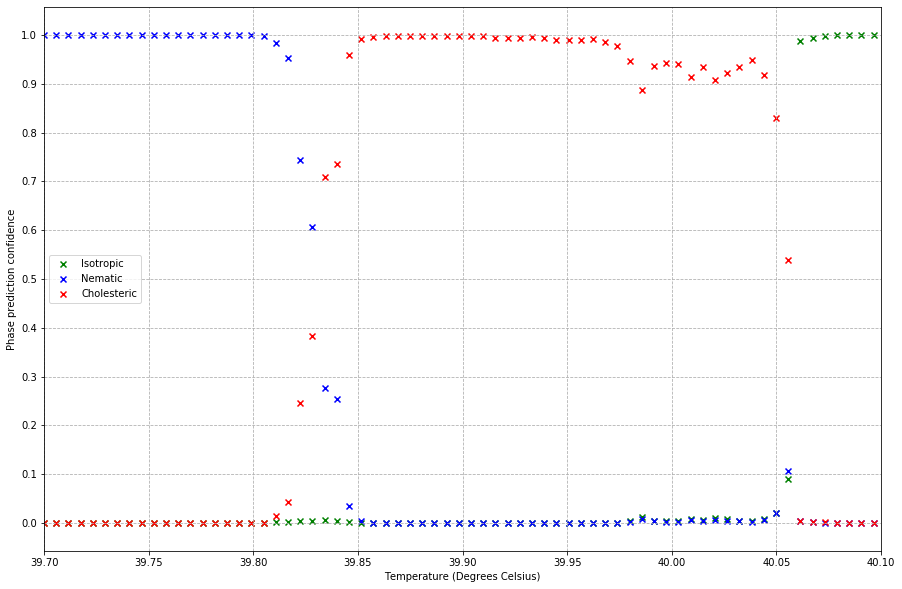

In [53]:
plt.figure(figsize=(15,10))
plt.scatter(temp, iso, c="g", marker="x", label="Isotropic")
plt.scatter(temp, nematic, c="b", marker="x", label="Nematic")
plt.scatter(temp, chol, c="r", marker="x", label="Cholesteric")
#plt.scatter(temp, smectic, c="black", marker="x", label="Smectic")

plt.xlabel("Temperature (Degrees Celsius)")
#plt.xticks(np.arange(32, 36.1, 0.05))
plt.xlim(39.7,40.1)
plt.ylabel("Phase prediction confidence")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.legend(loc="best")
plt.grid(linestyle="--")

plt.savefig(vid_name + "_transition_confidence-temp_graph")